In [1]:
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

>
Loading device for training

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

>
Initializing the transsforms for the images

In [3]:
# Define hyperparameters
batch_size = 32
num_epochs = 15
learning_rate = 0.09

In [4]:
# Load and preprocess the dataset
transform = transforms.Compose(
            [transforms.Resize((150,150)), # Resize images to 150x150 pixels
            transforms.ToTensor(), # Convert images to tensors
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize images

In [5]:
trainset = torchvision.datasets.ImageFolder(root='./Dataset/seg_train', transform=transform)
testset = torchvision.datasets.ImageFolder(root='./Dataset/seg_test', transform=transform)

In [6]:
size_valid = 0.10

number_train = len(trainset)
indx = list(range(number_train))

np.random.shuffle(indx)
split = int(size_valid * number_train)

train_idx, valid_idx = indx[split:], indx[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [8]:
#create a val set by splitting the test set
valset, testset = torch.utils.data.random_split(testset, [len(testset)//2, len(testset)//2])
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [9]:
len(trainset), len(valset), len(testset)

(14034, 1500, 1500)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


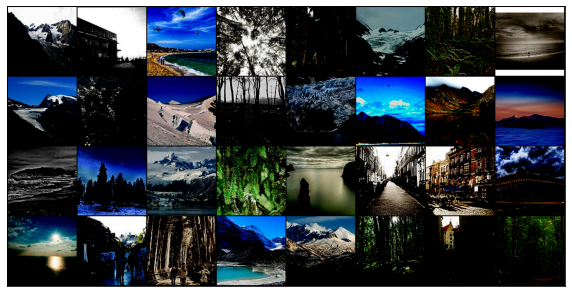

In [10]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(testloader)

# Model Training

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3) # Input channels: 3, output channels: 16, kernel size: 3
        self.conv2 = nn.Conv2d(16, 32, 3) # Input channels: 16, output channels: 32, kernel size: 3
        self.conv3 = nn.Conv2d(32, 64, 3) # Input channels: 32, output channels: 64, kernel size: 3
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2) # Kernel size: 2, stride: 2
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 17 * 17, 256) # Input features: 64 * 26 *26, output features: 256
        self.fc2 = nn.Linear(256, 6) # Input features: 256, output features:6 (number of classes)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply convolutional layers and pooling layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        # Flatten the output
        x = x.view(-1, 64 * 17 * 17)
        # Apply fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x    

In [12]:
# Create an instance of the model
model = Net().to(device)

In [13]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/15], Step [1/395], Loss: 1.7944680452346802, Accuracy: 12.5
Epoch [2/15], Step [1/395], Loss: 1.8096964359283447, Accuracy: 15.625
Epoch [3/15], Step [1/395], Loss: 1.786479115486145, Accuracy: 28.125
Epoch [4/15], Step [1/395], Loss: 1.780332326889038, Accuracy: 18.75
Epoch [5/15], Step [1/395], Loss: 1.8356921672821045, Accuracy: 6.25
Epoch [6/15], Step [1/395], Loss: 1.8282694816589355, Accuracy: 15.625
Epoch [7/15], Step [1/395], Loss: 1.7812690734863281, Accuracy: 21.875
Epoch [8/15], Step [1/395], Loss: 1.8015096187591553, Accuracy: 12.5
Epoch [9/15], Step [1/395], Loss: 1.8043092489242554, Accuracy: 9.375
Epoch [10/15], Step [1/395], Loss: 1.7903333902359009, Accuracy: 18.75
Epoch [11/15], Step [1/395], Loss: 1.7791777849197388, Accuracy: 31.25
Epoch [12/15], Step [1/395], Loss: 1.7825078964233398, Accuracy: 21.875
Epoch [13/15], Step [1/395], Loss: 1.7536139488220215, Accuracy: 25.0
Epoch [14/15], Step [1/395], Loss: 1.7900973558425903, Accuracy: 18.75
Epoch [15/15], S

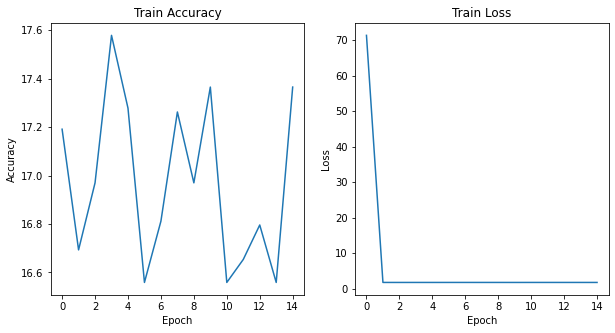

In [14]:
# Train the model
Train_Accuracy = []
Train_Loss = []
for epoch in range(num_epochs):
    running_loss = []
    running_acc = []
    val_loss = 0.0
    val_acc = 0.0
    # Loop over the training batches
    for i, data in enumerate(trainloader):
        # Get the inputs and the labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs).to(device)
        # Compute the loss and the accuracy
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, 1)
        acc = torch.sum(preds == labels) / batch_size
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss.append(loss.item())
        running_acc.append(acc.item())
        if i % 500 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(trainloader)}], Loss: {np.mean(running_loss)}, Accuracy: {np.mean(running_acc)*100}')
    Train_Accuracy.append(np.mean(running_acc)*100)
    Train_Loss.append(np.mean(running_loss))

print('Finished Training')
print('Train Accuracy: ', np.mean(Train_Accuracy))
print('Train Loss: ', np.mean(Train_Loss))

print('Sublpots of Train Accuracy and Train Loss')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(Train_Accuracy)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(Train_Loss)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Validation

Step: [1/47], Loss: 1.866926670074463, Accuracy: 6.25
Step: [36/47], Loss: 1.7976473338074155, Accuracy: 17.447916666666664
Finished Validation
Validation Accuracy:  17.287234042553195
Validation Loss:  1.8019984351827742
Subplots of Validation Accuracy and Validation Loss


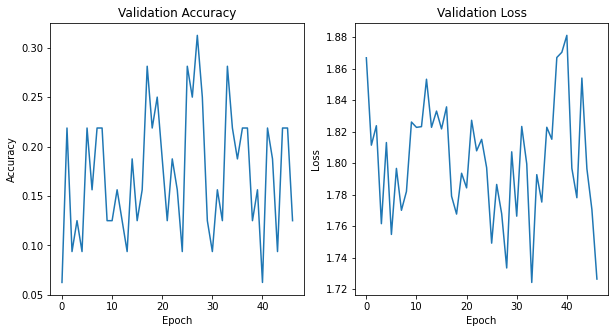

In [15]:
# Loop over the validation batches
with torch.no_grad():
    val_loss = []
    val_acc = []
    for i,data in enumerate(valloader):
        # Get the inputs and the labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)
        # Compute the loss and the accuracy
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = torch.sum(preds == labels) / batch_size
        # Print statistics
        val_loss.append(loss.item())
        val_acc.append(acc.item())
        if i % 35 == 0:
            print(f'Step: [{i + 1}/{len(valloader)}], Loss: {np.mean(val_loss)}, Accuracy: {np.mean(val_acc)*100}')

print('Finished Validation')
print('Validation Accuracy: ', np.mean(val_acc)*100)
print('Validation Loss: ', np.mean(val_loss))

print('Subplots of Validation Accuracy and Validation Loss')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(val_acc)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(val_loss)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

>
# Making Predictions and Displaying

In [16]:
idx_to_class = {0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [17]:
def Show_Prediction(image, pred, actual):
    plt.figure(figsize=(6,6))
    plt.imshow(image.cpu().permute(1,2,0))
    plt.title(f'Actual: {idx_to_class[actual.item()]}, Prediction: {idx_to_class[pred.item()]}')
    plt.show()

In [25]:
#Inverse transform for the images to be displayed
inv_transform = transforms.Compose([transforms.Normalize(mean=[-0.5/0.5,-0.5/0.5,-0.5/0.5], std=[1/0.5, 1/0.5, 1/0.5])])

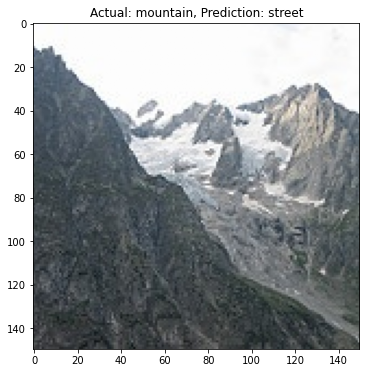

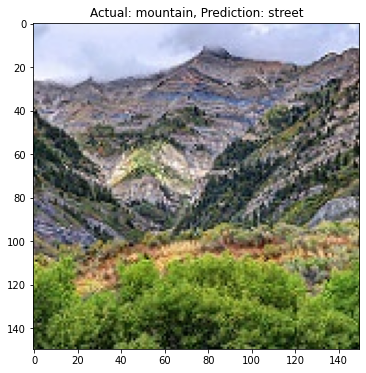

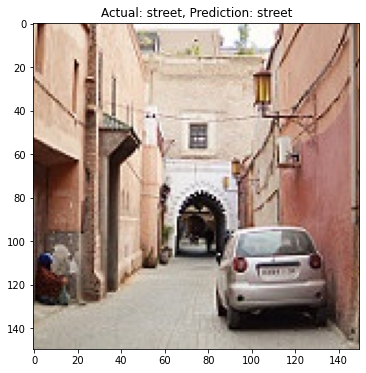

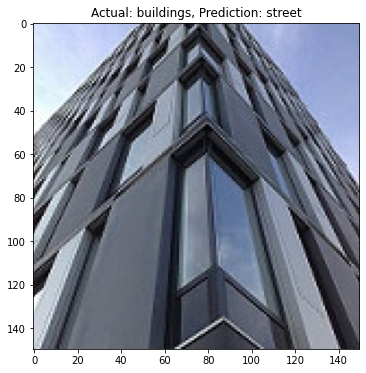

Test Accuracy of the network on the test images: 16.067 %


In [26]:
# Evaluate the model on the testing set
correct = 0
total = 0

# Loop over the testing batches
with torch.no_grad():
    for i,data in enumerate(testloader):
        # Get the inputs and the labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)

        # Compute the loss and the accuracy
        preds = torch.argmax(outputs, dim=1)

        if i % 15 == 0: 
            if np.shape(inputs)[0] == 1:
                image = inv_transform(inputs)
                Show_Prediction(image, preds, labels)
            else:
                image = inv_transform(inputs[0])
                Show_Prediction(image, preds[0], labels[0])

        # Print statistics
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print('\nTest Accuracy of the network on the test images: %.3f %%'% (100 * correct / total))